In [ ]:
# 1) 한글 폰트 설치 (Nanum + Noto CJK KR 백업)
!apt-get update -qq
!apt-get install -y fonts-nanum fonts-noto-cjk > /dev/null

# 2) Matplotlib에 폰트 즉시 등록(재시작 불필요) + 전역 설정
import os, glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 설치된 폰트 경로에서 ttf/otf 파일을 찾아 등록
font_dirs = [
    "/usr/share/fonts/truetype/nanum",
    "/usr/share/fonts/opentype/noto",
    "/usr/share/fonts/noto",
]
font_files = []
for d in font_dirs:
    if os.path.isdir(d):
        font_files += glob.glob(os.path.join(d, "**", "*.ttf"), recursive=True)
        font_files += glob.glob(os.path.join(d, "**", "*.otf"), recursive=True)

for f in font_files:
    try:
        fm.fontManager.addfont(f)
    except Exception:
        pass  # 읽지 못하는 폰트 파일은 건너뜀

# 선호 순서대로 사용할 폰트 이름 선택
preferred = [
    "NanumBarunGothic",  # 있으면 이걸 최우선
    "NanumGothic",
    "Noto Sans CJK KR",
    "Noto Sans KR",
    "NanumMyeongjo",
]
available = {f.name for f in fm.fontManager.ttflist}
font_name = next((name for name in preferred if name in available), None)

if font_name is None:
    raise RuntimeError("Korean font not found — 설치가 실패했을 수 있어요.")

mpl.rcParams["font.family"] = font_name
mpl.rcParams["axes.unicode_minus"] = False
print("Using font:", font_name)

# 3) 간단 테스트 플롯 (한글이 보이면 성공)
plt.figure()
plt.title("한글 제목 테스트 — 정상 동작하면 글자가 보입니다")
plt.plot([1, 2, 3], [1, 4, 9], marker="o")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.text(2, 7, "✅ 한글 OK, 마이너스 기호 OK: -1", ha="center")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os, re
from glob import glob
from tqdm import tqdm
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# **빅밸류 플랫폼 : http://bigvalue.ai**

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=68cfa2c578967" -O "data.xlsx"

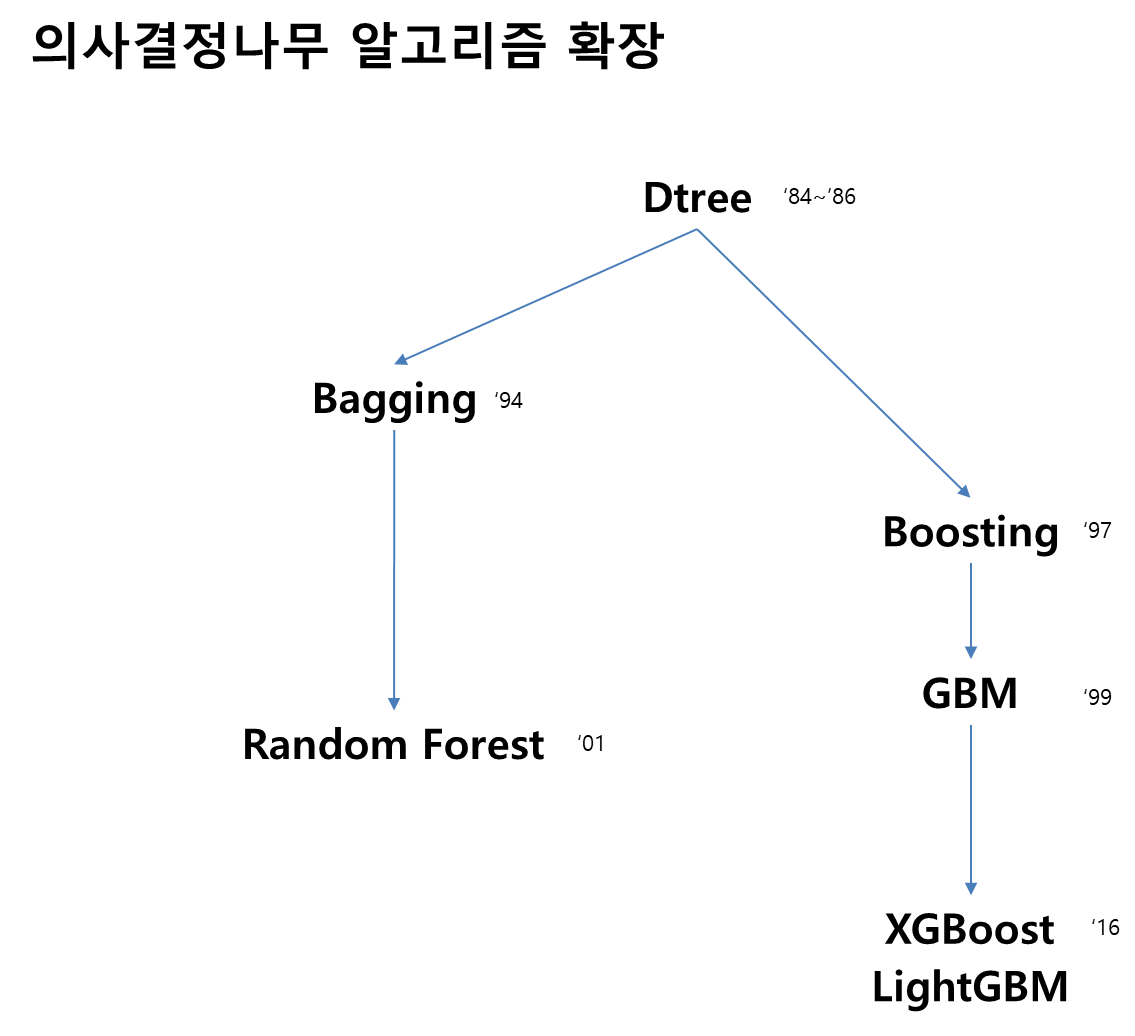

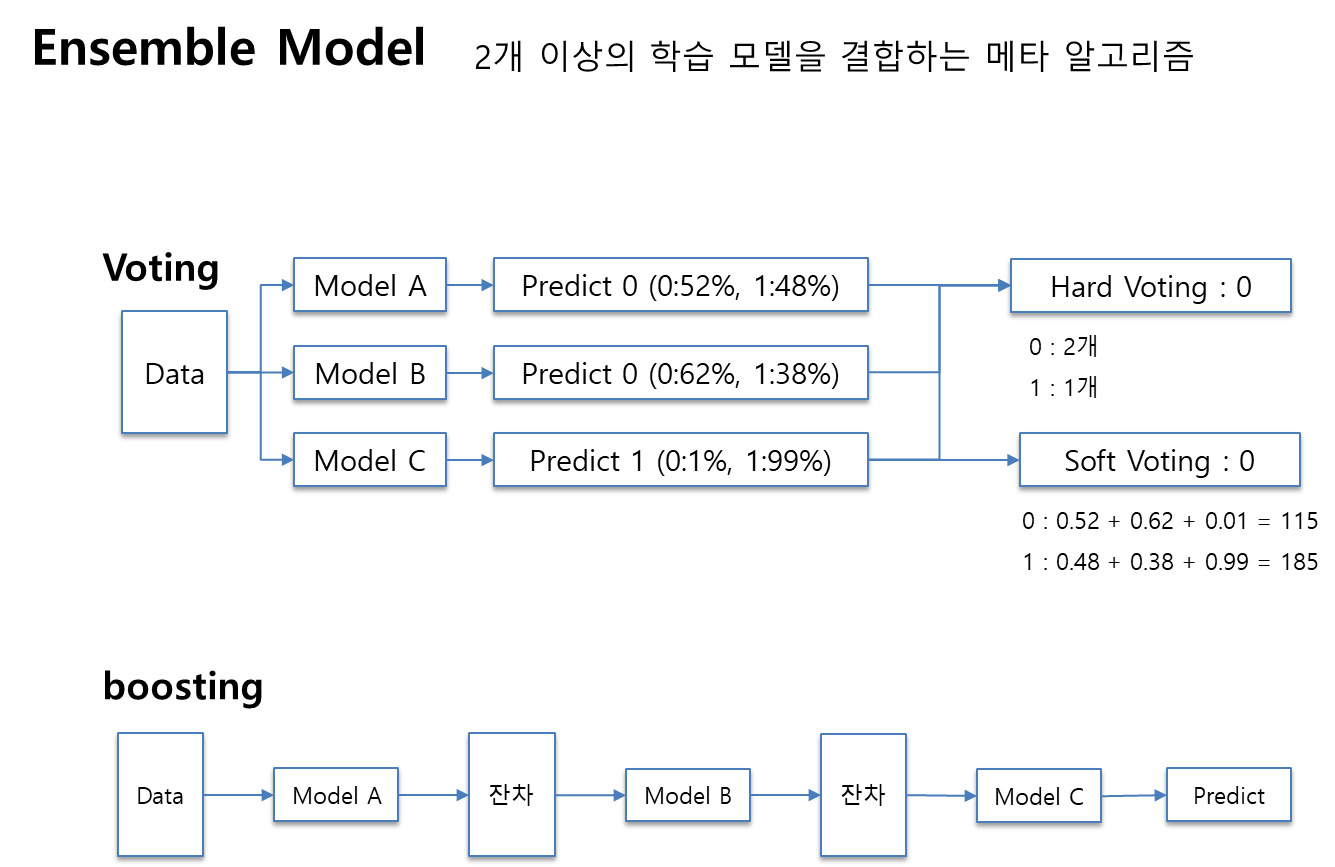

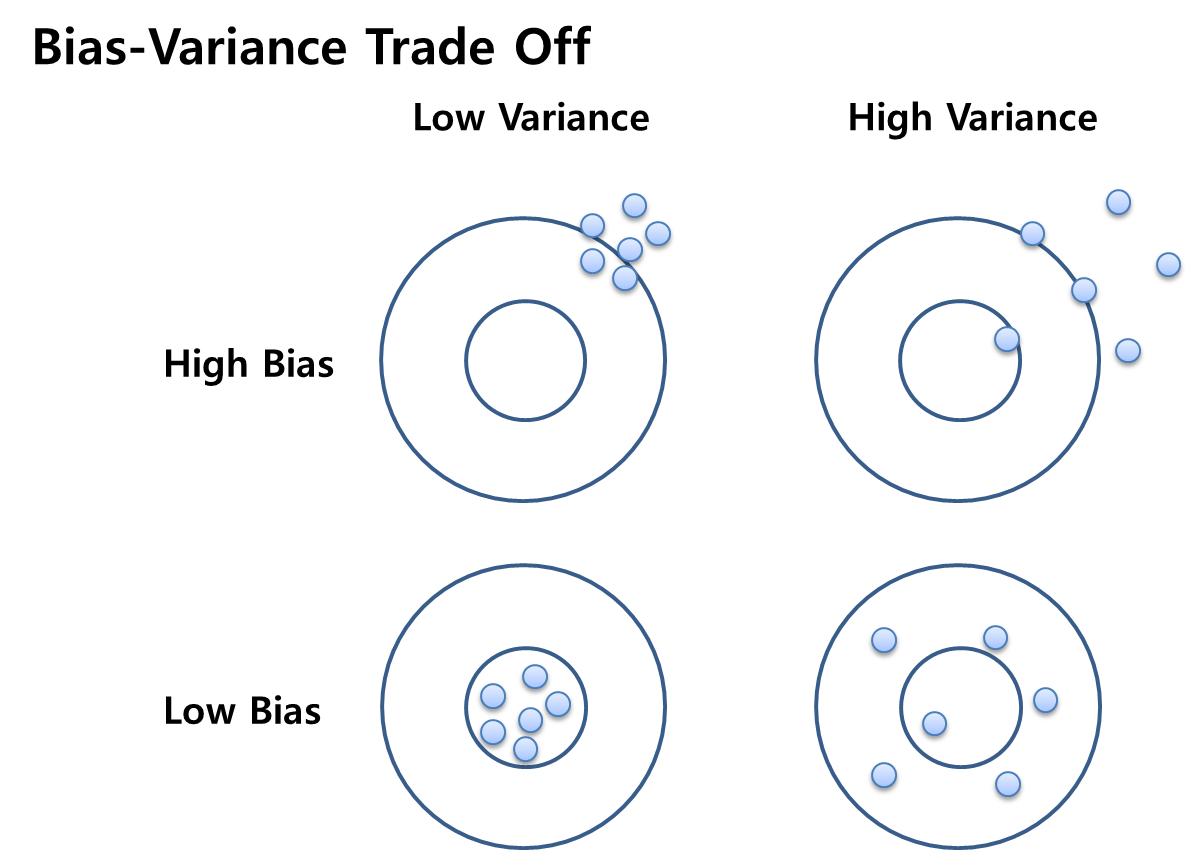

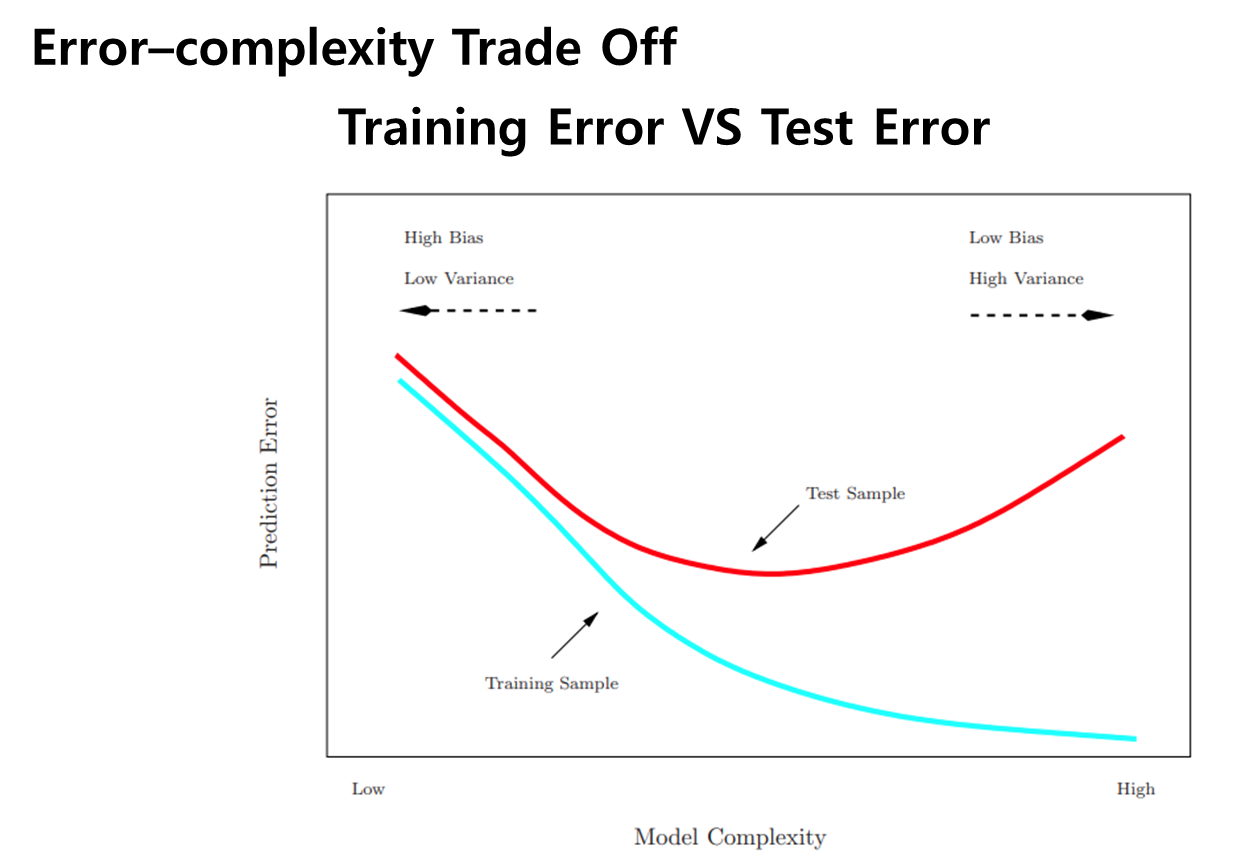

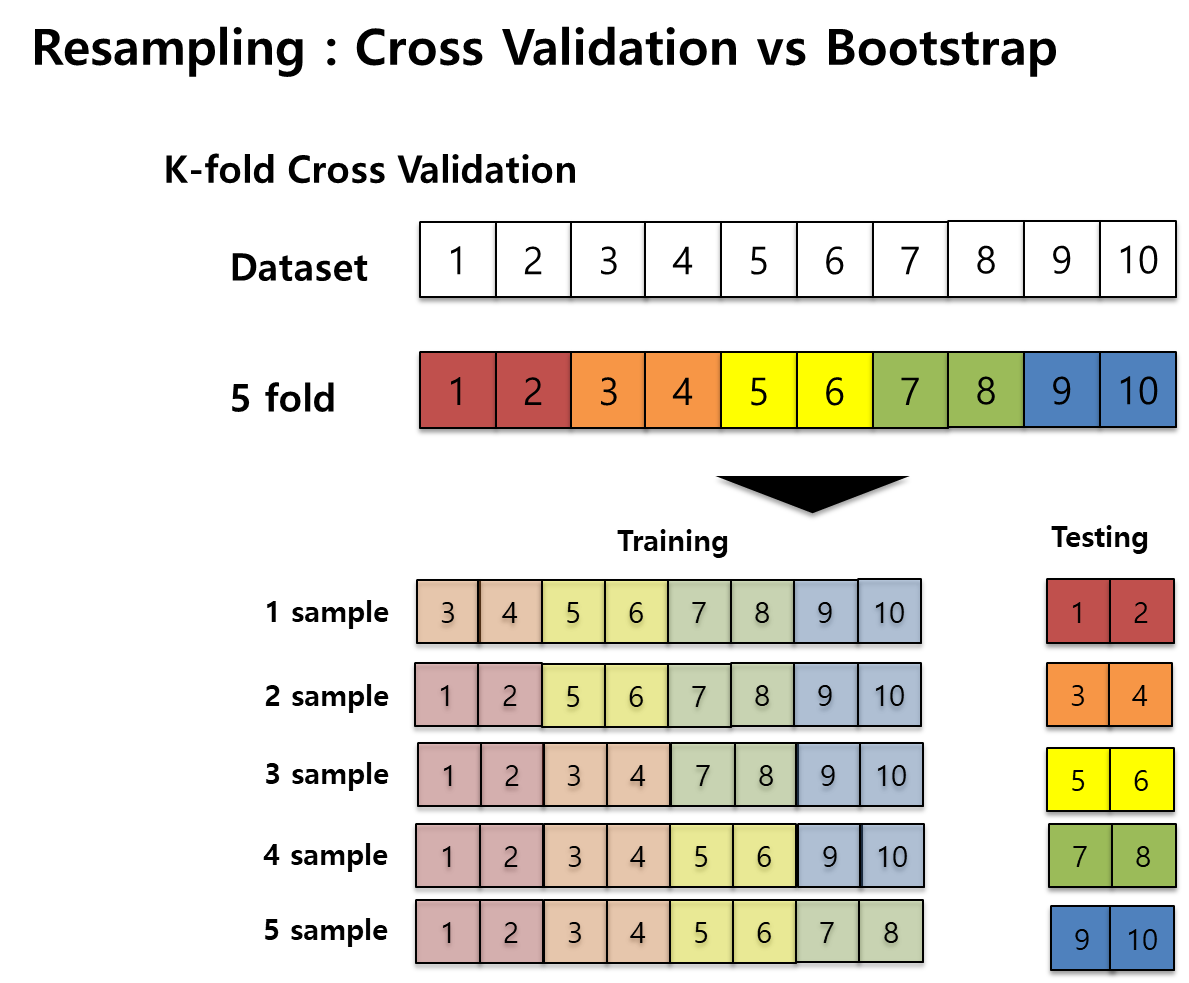

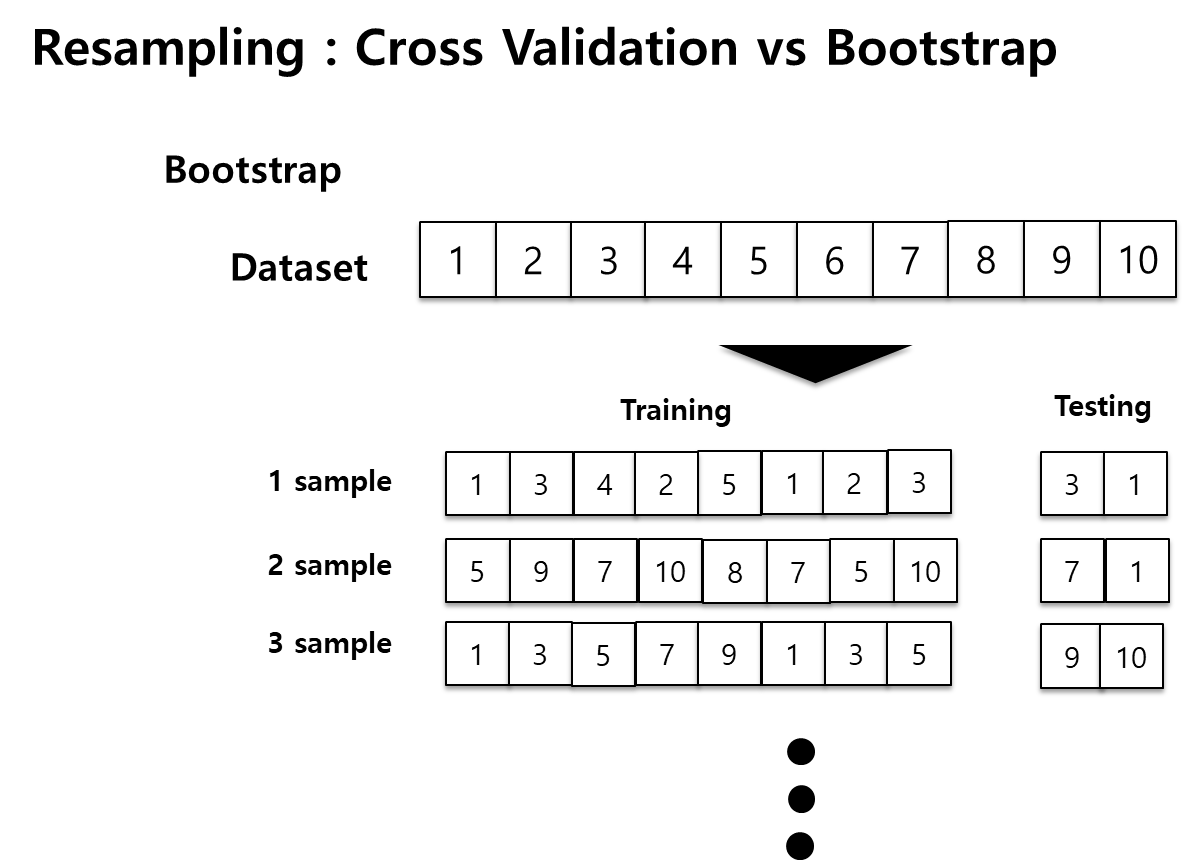

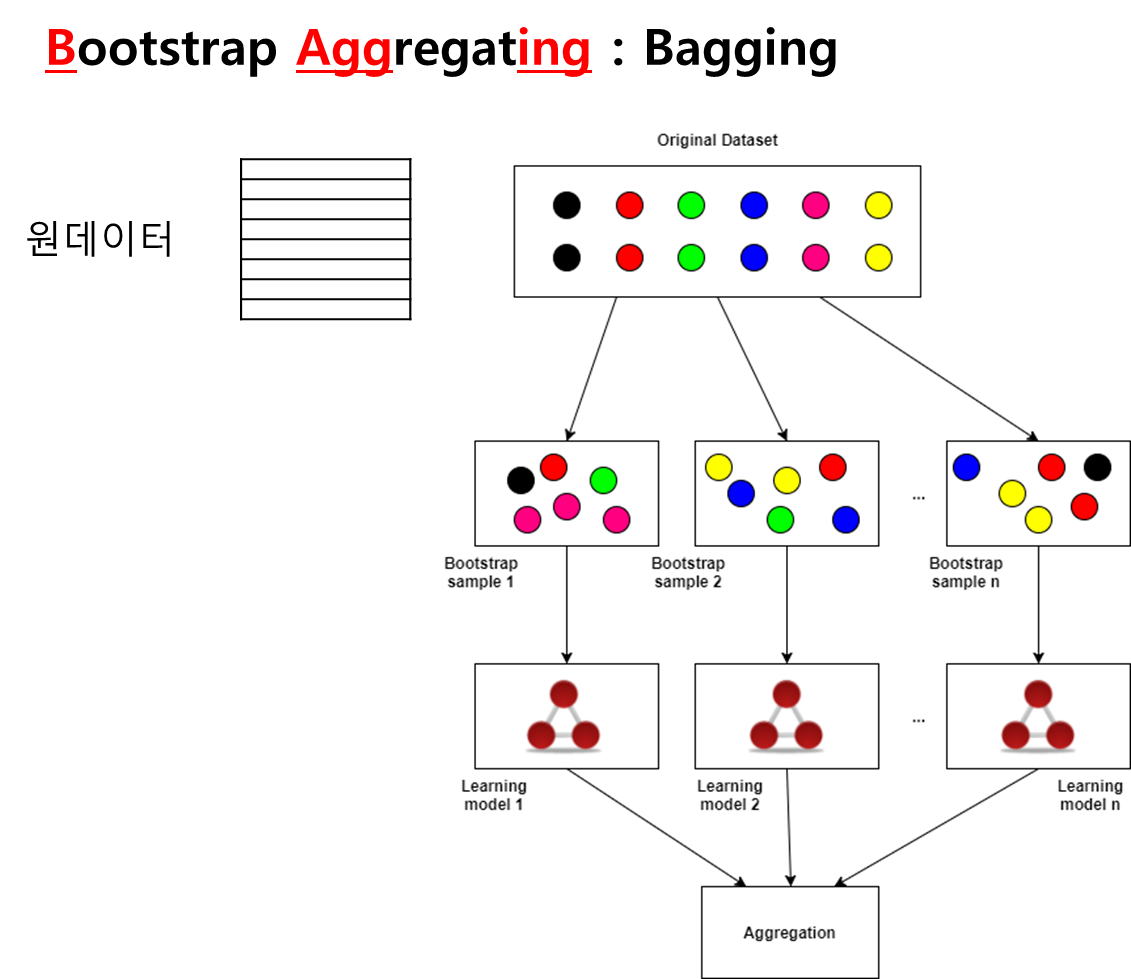

In [ ]:
"""학습용 데이터셋을 불러옴"""
data = pd.read_excel("data.xlsx", dtype='str')

int_cols = ['24년 총인구',
       '25년 총인구', '남성 총인구', '여성 총인구', '전체 0대', '전체 10대', '전체 20대',
       '전체 30대', '전체 40대', '전체 50대', '전체 60대', '전체 70대', '전체 80대',
       '전체 90대', '전체 100세 이상', '남성 0대', '남성 10대', '남성 20대', '남성 30대',
       '남성 40대', '남성 50대', '남성 60대', '남성 70대', '남성 80대', '남성 90대',
       '남성 100세 이상', '여성 0대', '여성 10대', '여성 20대', '여성 30대', '여성 40대',
       '여성 50대', '여성 60대', '여성 70대', '여성 80대', '여성 90대', '여성 100세 이상']

data[int_cols] = data[int_cols].astype('int')

data['인구증감'] = data.apply(lambda row: 0 if row['24년 총인구'] >= row['25년 총인구'] else 1, axis=1)
display(data.head())

In [72]:
x_cols = ['24년 총인구', '남성 총인구', '여성 총인구', '전체 0대', '전체 10대', '전체 20대',
       '전체 30대', '전체 40대', '전체 50대', '전체 60대', '전체 70대', '전체 80대',
       '전체 90대', '전체 100세 이상', '남성 0대', '남성 10대', '남성 20대', '남성 30대',
       '남성 40대', '남성 50대', '남성 60대', '남성 70대', '남성 80대', '남성 90대',
       '남성 100세 이상', '여성 0대', '여성 10대', '여성 20대', '여성 30대', '여성 40대',
       '여성 50대', '여성 60대', '여성 70대', '여성 80대', '여성 90대', '여성 100세 이상']

In [ ]:
"""
x_cols 내 데이터간 상관관계 비교 후 인구증감 데이터를 종속으로 표시
"""
# x_cols 데이터프레임 생성
x_data = data[x_cols]

# 상관관계 행렬 계산
correlation_matrix = x_data.corr()

# 자기 자신과의 상관관계(1)와 중복 값을 제외하고 가장 낮은 상관관계 값을 가진 두 변수 찾기
# 절대값 기준으로 가장 낮은 상관관계를 찾습니다.
stacked_corr = correlation_matrix.stack()
# Remove self-correlations and duplicate pairs
stacked_corr = stacked_corr[stacked_corr.index.get_level_values(0) < stacked_corr.index.get_level_values(1)]
min_corr_pair = stacked_corr.abs().idxmin()
feature1, feature2 = min_corr_pair

print(f"두 변수 간의 가장 낮은 상관관계: {correlation_matrix.loc[feature1, feature2]:.4f}")
print(f"가장 낮은 상관관계를 갖는 두 변수: '{feature1}'과 '{feature2}'")

# 인구증감 데이터를 종속 변수로 사용
# 인구증감 1: 인구 증가, 0: 인구 감소 또는 동일
data_increase = data[data['인구증감'] == 1]
data_decrease = data[data['인구증감'] == 0]


plt.figure(figsize=(9, 9))
plt.scatter(x=data_increase[feature1], y=data_increase[feature2], marker='x', color='red', label='인구 증가')
plt.scatter(x=data_decrease[feature1], y=data_decrease[feature2], marker='o', color='blue', label='인구 감소 또는 동일')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f"'{feature1}' vs '{feature2}'에 따른 인구증감 분포")
plt.legend(fontsize=10)
plt.show()

In [ ]:
""" 모든 입력변수를 이용한 분석"""
x = np.array(data[x_cols].fillna(0).astype('float').values)
y = np.array(data['인구증감'].values)
y = y.reshape(y.shape[0], 1)

print(x.shape)
print(y.shape)

In [ ]:
# prompt: Dtree 로 분석한 tree_clf가 depth가 증가할수록 정확도가 어떻게 증가하는지 보여줘

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

train_accuracies = []
test_accuracies = []

for depth in range(1, 11):  # depth 1부터 10까지
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_clf.fit(X_train, y_train)

    y_train_pred = tree_clf.predict(X_train)
    y_test_pred = tree_clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth')
plt.legend()
plt.show()


In [ ]:
"""Bagging Tree"""
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier

"""데이터 나누기"""
#데이터를 training과 testing으로 나눈다
x_train, x_test, y_train, y_test = train_test_split(x,y,                #분할할 행렬
                                                    test_size=0.25,     #검증세트의 분할 비율
                                                    random_state=1,     #순서 섞을 경우 랜덤시드 고정용
                                                    shuffle=True,       #순서 섞을지
                                                    stratify=y)         #분할시 데이터 비율 유지
print(sum(y) / len(y))
print(sum(y_train) / len(y_train))
print(sum(y_test) / len(y_test))


In [ ]:
y_test.shape

In [ ]:
# prompt: BaggingClassifier로 dtree max_depth를 3으로 제한한 상태에서 estimator를 늘리면서 train과 test의 정확도가 어떻게 변하는지 보여줘

train_accuracies = []
test_accuracies = []
estimator_range = range(1, 101, 5)  # 1부터 100까지 5씩 증가

for n_estimators in estimator_range:
    model_baggingtree = BaggingClassifier(
        DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators
    )
    model_baggingtree.fit(x_train, y_train.ravel())

    train_accuracy = model_baggingtree.score(x_train, y_train)
    test_accuracy = model_baggingtree.score(x_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_accuracies, label="Train Accuracy")
plt.plot(estimator_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators (Bagging with max_depth=3)")
plt.legend()
plt.show()


In [ ]:
feature_imp = np.mean([
    tree.feature_importances_ for tree in model_baggingtree.estimators_
], axis=0)
n_feature = len(x_cols)
idx = np.arange(n_feature)
sorted_idx = feature_imp.argsort()

# Convert x_cols to a NumPy array for indexing
x_cols_array = np.array(x_cols)

plt.figure(figsize=(5, int(n_feature / 3)))
plt.barh(idx, feature_imp[sorted_idx], align='center')
plt.yticks(idx, x_cols_array[sorted_idx])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

# Add the feature importance values next to the bars
for i, v in enumerate(feature_imp[sorted_idx]):
    plt.text(v, i, f"{v:.4f}", ha='left', va='center')

plt.show()

In [ ]:
"""Visualize a specific tree from the BaggingClassifier"""
from sklearn.tree import export_graphviz
from graphviz import Source

# Choose the index of the tree you want to visualize (e.g., the first tree is at index 0)
tree_index = 0

if tree_index < len(model_baggingtree.estimators_):
    tree_to_visualize = model_baggingtree.estimators_[tree_index]

    dt_dot_data  = export_graphviz(tree_to_visualize,
                                   feature_names=x_cols,
                                   class_names=['감소', '증가'],         # 종속변수
                                   rounded = True,
                                   filled = True)

    graph = Source(dt_dot_data)
    display(graph)
else:
    print(f"Tree index {tree_index} is out of bounds. The BaggingClassifier has {len(model_baggingtree.estimators_)} trees.")

In [ ]:
"""Analyze the first split feature of each tree in BaggingClassifier"""
first_split_features = []

for tree in model_baggingtree.estimators_:
    # Access the feature used for the first split (root node)
    # The tree structure is represented by tree_.tree_
    # tree_.tree_.feature[0] gives the index of the feature used at the root
    first_split_feature_index = tree.tree_.feature[0]

    # If the first split is not a leaf node (feature index is not _tree.TREE_LEAF)
    if first_split_feature_index != -2: # _tree.TREE_LEAF is -2
        first_split_features.append(x_cols[first_split_feature_index])
    else:
        # Handle cases where the tree might be a leaf node from the start
        first_split_features.append("Leaf node at root")

# Count the occurrences of each feature
from collections import Counter
feature_counts = Counter(first_split_features)

print("Count of features used for the first split in BaggingClassifier:")
for feature, count in feature_counts.most_common():
    print(f"- {feature}: {count} times")

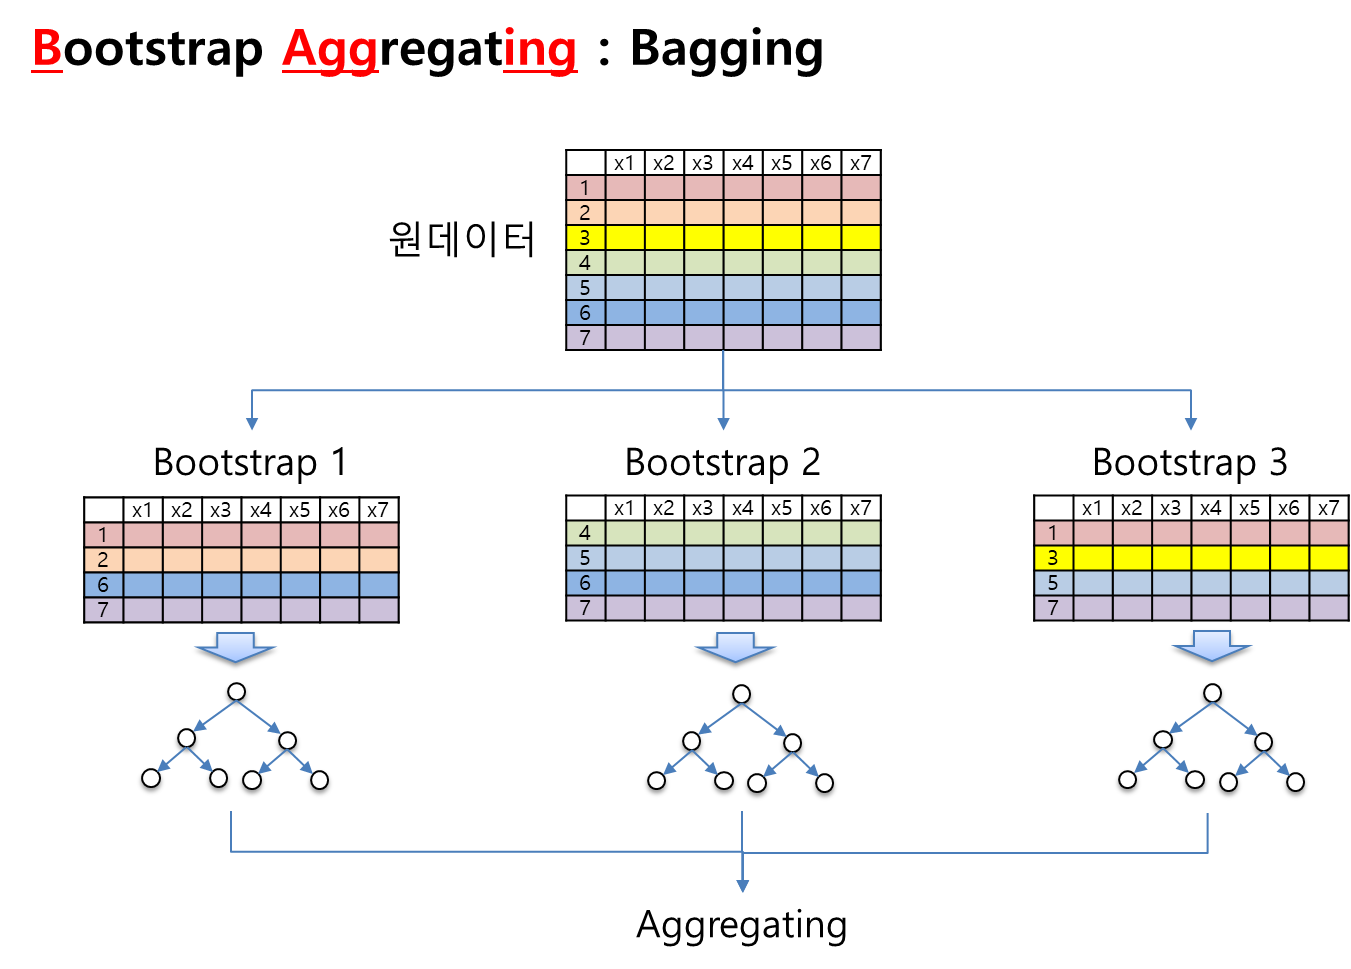

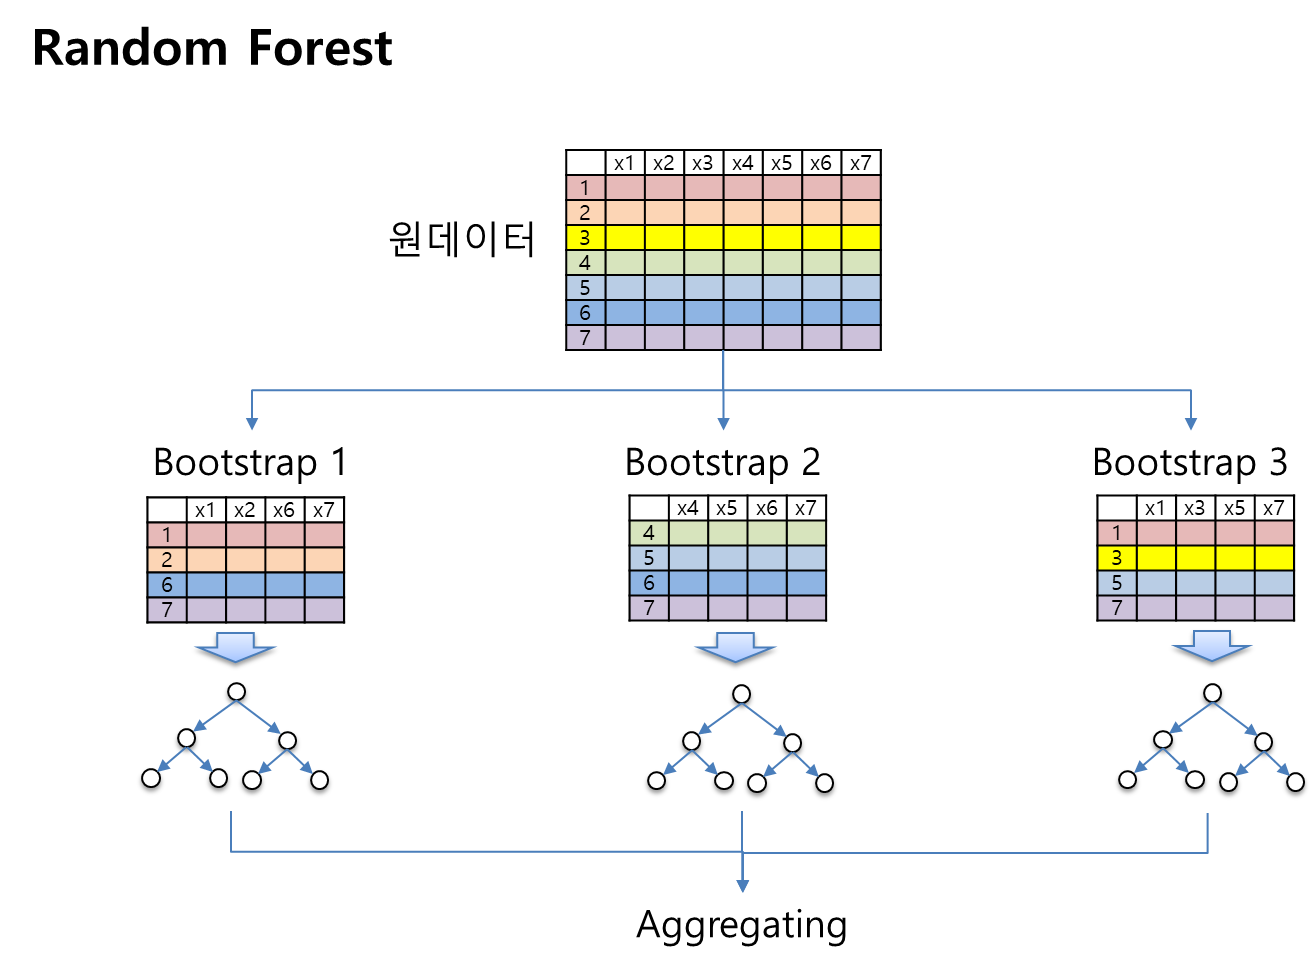

In [ ]:
# prompt: RandomForestClassifier로 dtree max_depth를 3으로 제한한 상태에서 estimator를 늘리면서 train과 test의 정확도가 어떻게 변하는지 보여줘

from sklearn.ensemble import RandomForestClassifier

train_accuracies = []
test_accuracies = []
estimator_range = range(1, 101,5)  # 1부터 100까지 5씩 증가

for n_estimators in tqdm(estimator_range):
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=3, random_state=42)
    rf_classifier.fit(x_train, y_train.ravel())

    train_accuracy = rf_classifier.score(x_train, y_train)
    test_accuracy = rf_classifier.score(x_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_accuracies, label='Train Accuracy')
plt.plot(estimator_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs. Number of Estimators (RandomForest, max_depth=3)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Choose the index of the tree you want to visualize (e.g., the first tree is at index 0)
tree_index = 0

m = rf_classifier[tree_index]
dt_dot_data  = export_graphviz(m,
                               feature_names=x_cols,
                               class_names=['감소', '증가'],         # 종속변수
                               rounded = True,
                               filled = True)

graph = Source(dt_dot_data)
display(graph)

In [ ]:
"""Analyze the first split feature of each tree in RandomForestClassifier"""
first_split_features = []

for tree in rf_classifier.estimators_:
    # Access the feature used for the first split (root node)
    # The tree structure is represented by tree_.tree_
    # tree_.tree_.feature[0] gives the index of the feature used at the root
    first_split_feature_index = tree.tree_.feature[0]

    # If the first split is not a leaf node (feature index is not _tree.TREE_LEAF)
    if first_split_feature_index != -2: # _tree.TREE_LEAF is -2
        first_split_features.append(x_cols[first_split_feature_index])
    else:
        # Handle cases where the tree might be a leaf node from the start
        first_split_features.append("Leaf node at root")

# Count the occurrences of each feature
from collections import Counter
feature_counts = Counter(first_split_features)

print("Count of features used for the first split in RandomForestClassifier:")
for feature, count in feature_counts.most_common():
    print(f"- {feature}: {count} times")

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=3)
rf_classifier.fit(x_train, y_train.ravel())

"""변수중요도"""
feature_imp = np.mean([
    tree.feature_importances_ for tree in rf_classifier.estimators_
], axis=0)
n_feature = len(x_cols)
idx = np.arange(n_feature)
sorted_idx = feature_imp.argsort()

# Convert x_cols to a NumPy array for indexing
x_cols_array = np.array(x_cols)

plt.figure(figsize=(5, int(n_feature/3)))
plt.barh(idx, feature_imp[sorted_idx], align='center')
plt.yticks(idx, x_cols_array[sorted_idx])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

# Re-train the RandomForestClassifier with a deeper max_depth
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=10, random_state=42)
rf_classifier.fit(x_train, y_train.ravel())

result = permutation_importance(rf_classifier, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

# Convert x_cols to a NumPy array for indexing
x_cols_array = np.array(x_cols)

plt.figure(figsize=(5, int(n_feature/3)))
plt.boxplot(result.importances[sorted_idx].T,
           vert=False, tick_labels=x_cols_array[sorted_idx]) # Use tick_labels instead of labels

plt.show()